In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,  confusion_matrix, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Multiply, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [8]:
class_labels = pd.Series(["Walking", "Jogging", "walking_stairs_updown", "stumble_while_walking", "Fall_Recovery", "Fall_Initiation", "Impact", "Aftermath"])
n_classes = len(class_labels)
print("Number of Classes :", n_classes)

Number of Classes : 8


In [9]:
final_data = np.load("full_and_half_Final_data.npy")
print("Shape of Final Data :", final_data.shape)
final_data

Shape of Final Data : (11674, 200, 6)


array([[[ 3.70108067e-01,  1.84242152e+00, -2.09895659e+00,
          2.44204856e-01, -1.14811268e+00, -1.31094327e+00],
        [ 3.10724502e-01,  1.96257422e+00, -1.87010434e+00,
          7.64817407e-02, -1.28869163e+00, -1.17169055e+00],
        [-1.04960451e-01,  1.91451314e+00, -1.64125208e+00,
         -7.20730188e-02, -1.38753620e+00, -1.06573740e+00],
        ...,
        [-6.09720751e-01,  6.41615423e-02,  1.51182342e+00,
         -3.37363067e-02, -1.84222124e+00,  4.14579566e-01],
        [-7.28487880e-01,  4.01310021e-02,  1.56267948e+00,
          1.77115610e-01, -1.91910036e+00,  5.08423791e-01],
        [-8.17563227e-01, -1.04052239e-01,  1.86781582e+00,
          4.21512150e-01, -1.98938983e+00,  6.08322481e-01]],

       [[-7.14277170e-01,  2.00488654e-01,  1.69094994e+00,
          1.68401107e-01, -1.84585613e+00,  5.43452106e-01],
        [-7.71764267e-01,  2.00488654e-01,  1.75142020e+00,
          3.39260497e-01, -1.88641103e+00,  5.58390904e-01],
        [-7.52601

In [10]:
label = np.load("full_and_half_label.npy")
print("Shape of Label :", label.shape)
label

Shape of Label : (11674,)


array([0, 0, 0, ..., 5, 6, 7])

In [11]:
frequency = np.bincount(label)
frequency

array([1520, 1480, 1540,  279,  279, 3288, 1644, 1644])

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Walking'),
  Text(1, 0, 'Jogging'),
  Text(2, 0, 'walking_stairs_updown'),
  Text(3, 0, 'stumble_while_walking'),
  Text(4, 0, 'Fall_Recovery'),
  Text(5, 0, 'Fall_Initiation'),
  Text(6, 0, 'Impact'),
  Text(7, 0, 'Aftermath')])

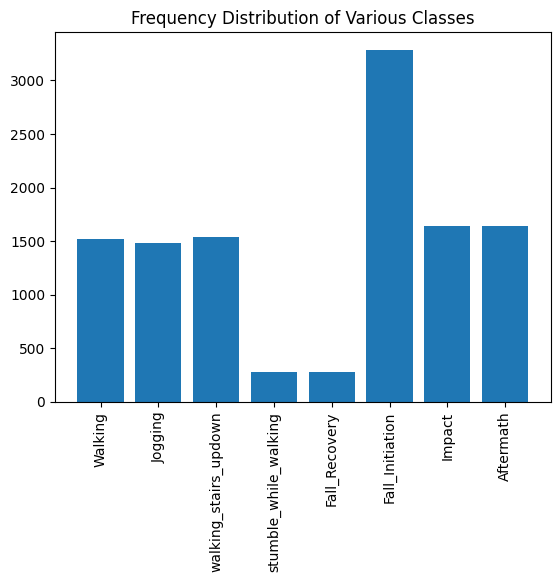

In [12]:
plt.bar(class_labels, frequency)
plt.title("Frequency Distribution of Various Classes")
plt.xticks(rotation=90)

In [13]:
label = to_categorical(label, n_classes)
print("Shape of Label :", label.shape)
label

Shape of Label : (11674, 8)


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [14]:
final_data = zscore(final_data, axis=1)
final_data

array([[[ 3.70108067e-01,  1.84242152e+00, -2.09895659e+00,
          2.44204856e-01, -1.14811268e+00, -1.31094327e+00],
        [ 3.10724502e-01,  1.96257422e+00, -1.87010434e+00,
          7.64817407e-02, -1.28869163e+00, -1.17169055e+00],
        [-1.04960451e-01,  1.91451314e+00, -1.64125208e+00,
         -7.20730188e-02, -1.38753620e+00, -1.06573740e+00],
        ...,
        [-6.09720751e-01,  6.41615423e-02,  1.51182342e+00,
         -3.37363067e-02, -1.84222124e+00,  4.14579566e-01],
        [-7.28487880e-01,  4.01310021e-02,  1.56267948e+00,
          1.77115610e-01, -1.91910036e+00,  5.08423791e-01],
        [-8.17563227e-01, -1.04052239e-01,  1.86781582e+00,
          4.21512150e-01, -1.98938983e+00,  6.08322481e-01]],

       [[-7.14277170e-01,  2.00488654e-01,  1.69094994e+00,
          1.68401107e-01, -1.84585613e+00,  5.43452106e-01],
        [-7.71764267e-01,  2.00488654e-01,  1.75142020e+00,
          3.39260497e-01, -1.88641103e+00,  5.58390904e-01],
        [-7.52601

In [15]:
I_Shape = final_data.shape[1:]
I_Shape

(200, 6)

In [19]:
def selective_kernel_conv(inputs, kernel_sizes, filters, use_bn=True, dropout_rate=0.3):
    conv_outputs = []
    for size in kernel_sizes:
        conv_output = Conv1D(filters=filters, kernel_size=size, padding='same', activation='relu')(inputs)
        if use_bn:
            conv_output = tf.keras.layers.BatchNormalization()(conv_output)
        conv_outputs.append(conv_output)

    if len(conv_outputs) > 1:
        combined_output = Add()(conv_outputs)
    else:
        combined_output = conv_outputs[0]

    excitation = GlobalAveragePooling1D()(combined_output)
    excitation = Dense(len(kernel_sizes), activation='relu')(excitation)
    excitation = Dense(filters, activation='sigmoid')(excitation)
    excitation = tf.expand_dims(excitation, axis=1)

    weighted_output = Multiply()([combined_output, excitation])

    if dropout_rate:
        weighted_output = Dropout(dropout_rate)(weighted_output)

    return weighted_output

def attention_block(inputs):
    attention_scores = Dense(inputs.shape[-1], activation='softmax')(inputs)
    attention_output = Multiply()([inputs, attention_scores])
    return attention_output

def ENSEMBLE(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = selective_kernel_conv(inputs, kernel_sizes=[3, 5], filters=32, dropout_rate=0.2)
    x = attention_block(x)

    x = selective_kernel_conv(x, kernel_sizes=[3, 5], filters=64, dropout_rate=0.2)
    x = attention_block(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
precisions = []
recalls = []
losses = []

Fold 1
Epoch 1/200
263/263 [==============================] - 10s 24ms/step - loss: 1.6095 - accuracy: 0.3982 - val_loss: 1.7202 - val_accuracy: 0.4625
Epoch 2/200
263/263 [==============================] - 6s 22ms/step - loss: 1.0204 - accuracy: 0.6466 - val_loss: 1.1467 - val_accuracy: 0.5803
Epoch 3/200
263/263 [==============================] - 6s 23ms/step - loss: 0.8369 - accuracy: 0.7073 - val_loss: 0.9267 - val_accuracy: 0.6360
Epoch 4/200
263/263 [==============================] - 6s 22ms/step - loss: 0.7331 - accuracy: 0.7490 - val_loss: 0.8979 - val_accuracy: 0.6542
Epoch 5/200
263/263 [==============================] - 6s 23ms/step - loss: 0.6853 - accuracy: 0.7622 - val_loss: 0.8299 - val_accuracy: 0.6906
Epoch 6/200
263/263 [==============================] - 6s 23ms/step - loss: 0.6468 - accuracy: 0.7843 - val_loss: 0.6400 - val_accuracy: 0.7784
Epoch 7/200
263/263 [==============================] - 6s 23ms/step - loss: 0.6095 - accuracy: 0.7917 - val_loss: 0.6265 - val_a

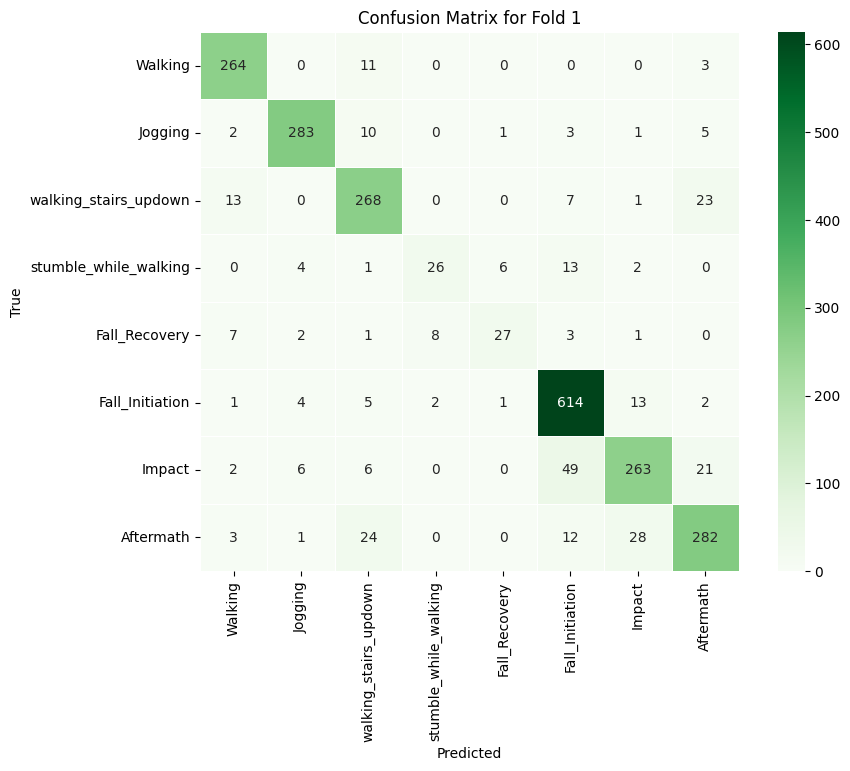

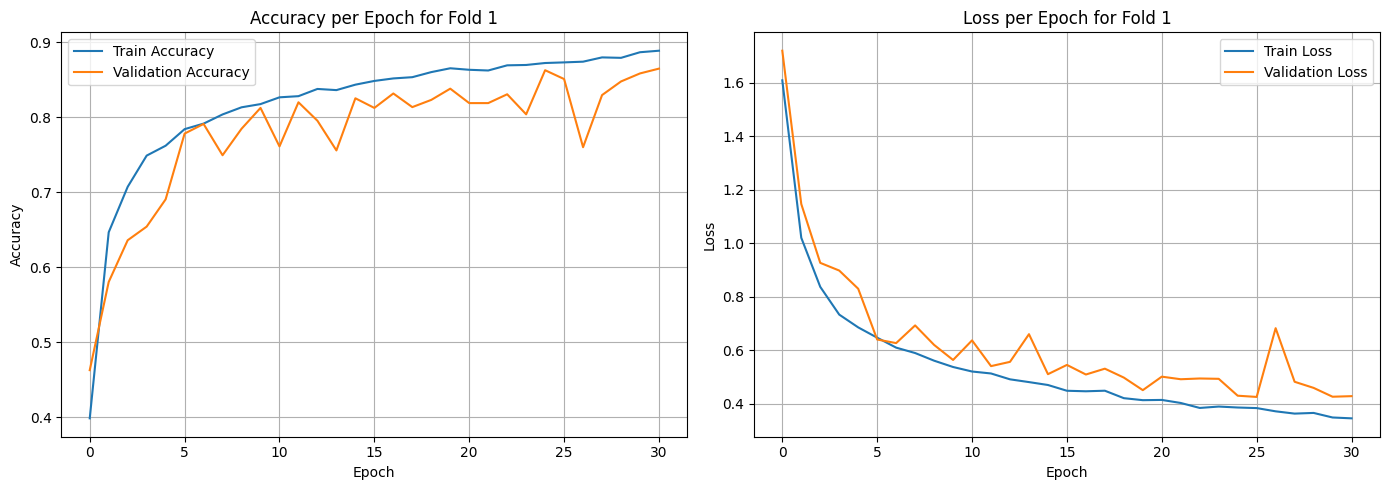

Fold 2
Epoch 1/200
263/263 [==============================] - 10s 24ms/step - loss: 1.6063 - accuracy: 0.4137 - val_loss: 1.9711 - val_accuracy: 0.0546
Epoch 2/200
263/263 [==============================] - 6s 22ms/step - loss: 1.0053 - accuracy: 0.6625 - val_loss: 1.1496 - val_accuracy: 0.6092
Epoch 3/200
263/263 [==============================] - 6s 22ms/step - loss: 0.8253 - accuracy: 0.7192 - val_loss: 0.9258 - val_accuracy: 0.6649
Epoch 4/200
263/263 [==============================] - 6s 22ms/step - loss: 0.7372 - accuracy: 0.7499 - val_loss: 0.8028 - val_accuracy: 0.6981
Epoch 5/200
263/263 [==============================] - 6s 22ms/step - loss: 0.6768 - accuracy: 0.7680 - val_loss: 0.8287 - val_accuracy: 0.6991
Epoch 6/200
263/263 [==============================] - 6s 22ms/step - loss: 0.6363 - accuracy: 0.7869 - val_loss: 0.6803 - val_accuracy: 0.7345
Epoch 7/200
263/263 [==============================] - 6s 22ms/step - loss: 0.6072 - accuracy: 0.7951 - val_loss: 0.6966 - val_a

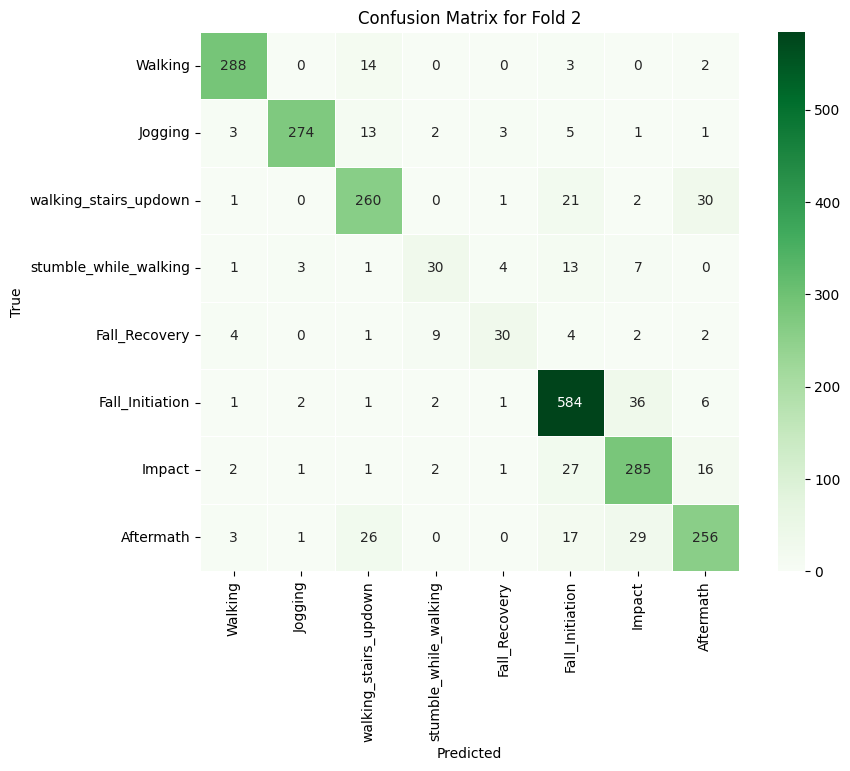

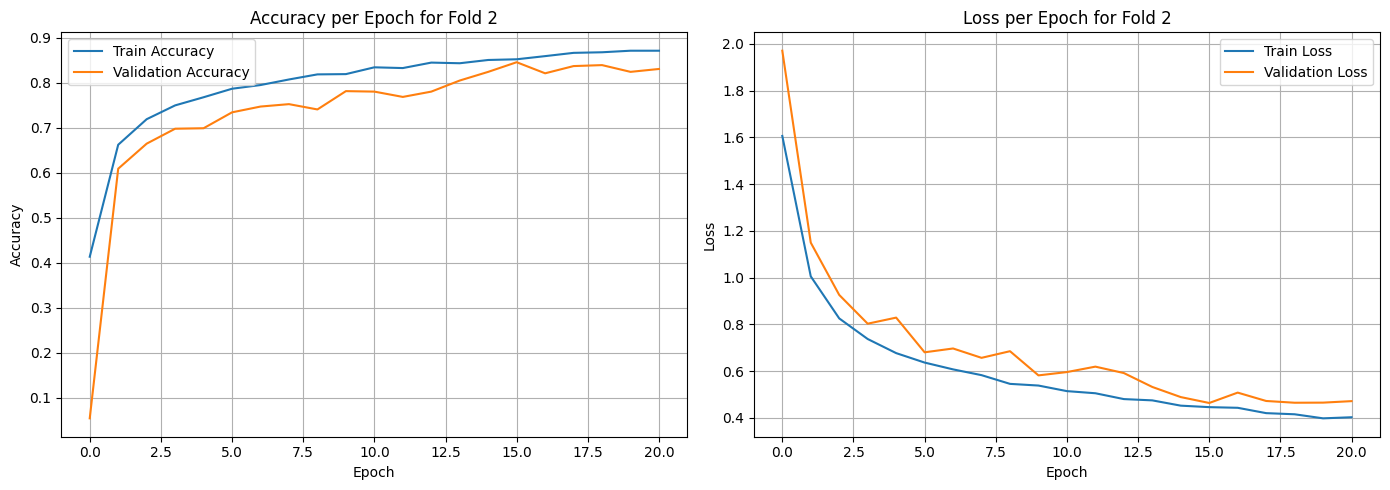

Fold 3
Epoch 1/200
263/263 [==============================] - 9s 24ms/step - loss: 1.6026 - accuracy: 0.4108 - val_loss: 1.7828 - val_accuracy: 0.3458
Epoch 2/200
263/263 [==============================] - 6s 23ms/step - loss: 1.0612 - accuracy: 0.6286 - val_loss: 1.1502 - val_accuracy: 0.6306
Epoch 3/200
263/263 [==============================] - 6s 23ms/step - loss: 0.8707 - accuracy: 0.7047 - val_loss: 0.9015 - val_accuracy: 0.6831
Epoch 4/200
263/263 [==============================] - 6s 22ms/step - loss: 0.7739 - accuracy: 0.7393 - val_loss: 0.8503 - val_accuracy: 0.6970
Epoch 5/200
263/263 [==============================] - 6s 22ms/step - loss: 0.7079 - accuracy: 0.7616 - val_loss: 0.7631 - val_accuracy: 0.7184
Epoch 6/200
263/263 [==============================] - 6s 23ms/step - loss: 0.6546 - accuracy: 0.7804 - val_loss: 0.6708 - val_accuracy: 0.7698
Epoch 7/200
263/263 [==============================] - 6s 23ms/step - loss: 0.6227 - accuracy: 0.7907 - val_loss: 0.6249 - val_ac

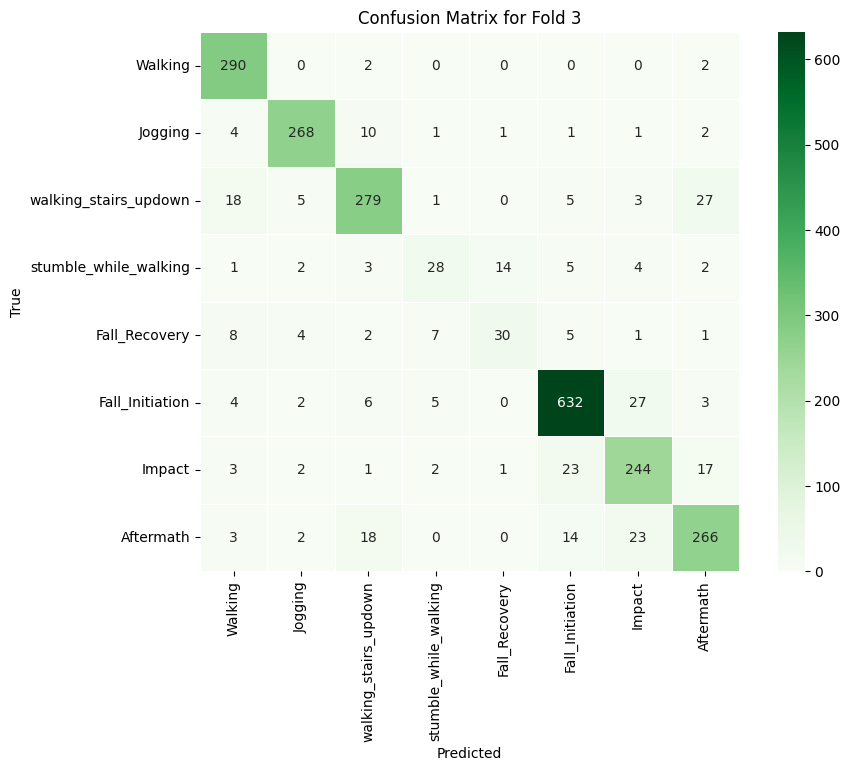

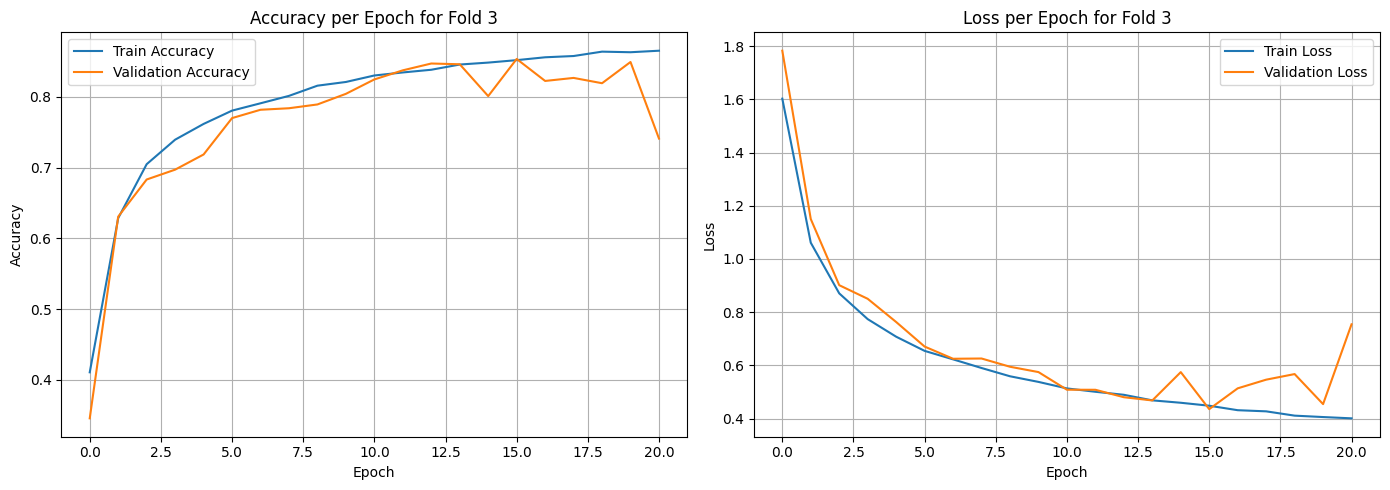

Fold 4
Epoch 1/200
263/263 [==============================] - 9s 24ms/step - loss: 1.6306 - accuracy: 0.3943 - val_loss: 1.8496 - val_accuracy: 0.2709
Epoch 2/200
263/263 [==============================] - 6s 22ms/step - loss: 1.0687 - accuracy: 0.6252 - val_loss: 1.1886 - val_accuracy: 0.5514
Epoch 3/200
263/263 [==============================] - 6s 22ms/step - loss: 0.8815 - accuracy: 0.6985 - val_loss: 0.9695 - val_accuracy: 0.6381
Epoch 4/200
263/263 [==============================] - 6s 23ms/step - loss: 0.7569 - accuracy: 0.7468 - val_loss: 0.8328 - val_accuracy: 0.6949
Epoch 5/200
263/263 [==============================] - 6s 23ms/step - loss: 0.6845 - accuracy: 0.7747 - val_loss: 0.7508 - val_accuracy: 0.7259
Epoch 6/200
263/263 [==============================] - 6s 23ms/step - loss: 0.6391 - accuracy: 0.7861 - val_loss: 0.7276 - val_accuracy: 0.7388
Epoch 7/200
263/263 [==============================] - 6s 23ms/step - loss: 0.6149 - accuracy: 0.7956 - val_loss: 0.6719 - val_ac

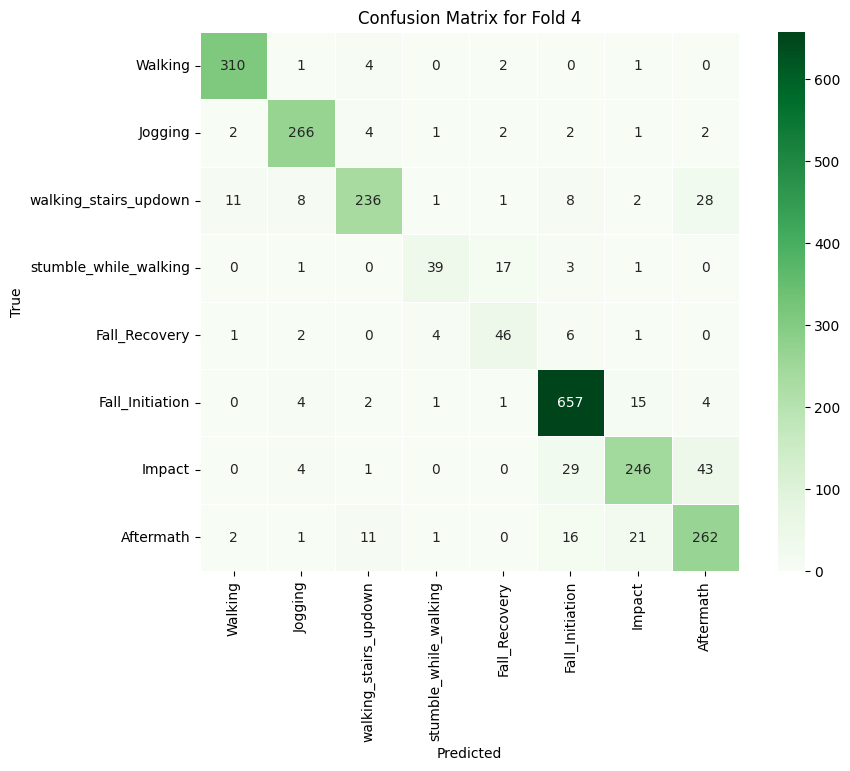

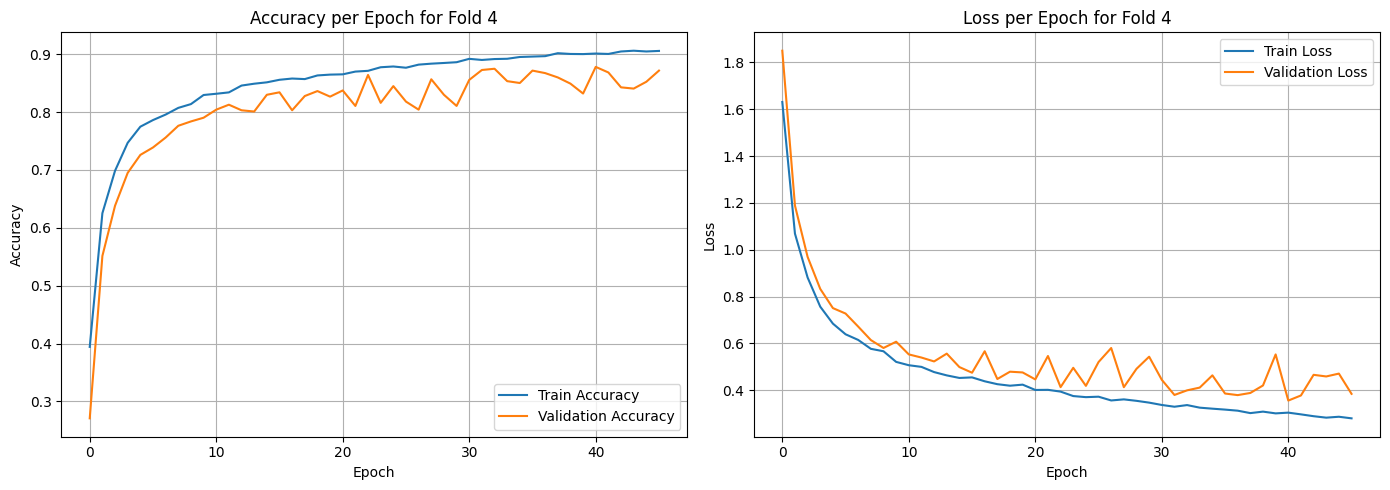

Fold 5
Epoch 1/200
263/263 [==============================] - 9s 24ms/step - loss: 1.6863 - accuracy: 0.3550 - val_loss: 1.8925 - val_accuracy: 0.4090
Epoch 2/200
263/263 [==============================] - 6s 22ms/step - loss: 1.1036 - accuracy: 0.6231 - val_loss: 1.1315 - val_accuracy: 0.6113
Epoch 3/200
263/263 [==============================] - 6s 22ms/step - loss: 0.9011 - accuracy: 0.6947 - val_loss: 0.9348 - val_accuracy: 0.6542
Epoch 4/200
263/263 [==============================] - 6s 22ms/step - loss: 0.7913 - accuracy: 0.7332 - val_loss: 0.7969 - val_accuracy: 0.7184
Epoch 5/200
263/263 [==============================] - 6s 22ms/step - loss: 0.7023 - accuracy: 0.7587 - val_loss: 0.7172 - val_accuracy: 0.7441
Epoch 6/200
263/263 [==============================] - 6s 22ms/step - loss: 0.6500 - accuracy: 0.7867 - val_loss: 0.6240 - val_accuracy: 0.7827
Epoch 7/200
263/263 [==============================] - 6s 22ms/step - loss: 0.6185 - accuracy: 0.8023 - val_loss: 0.6253 - val_ac

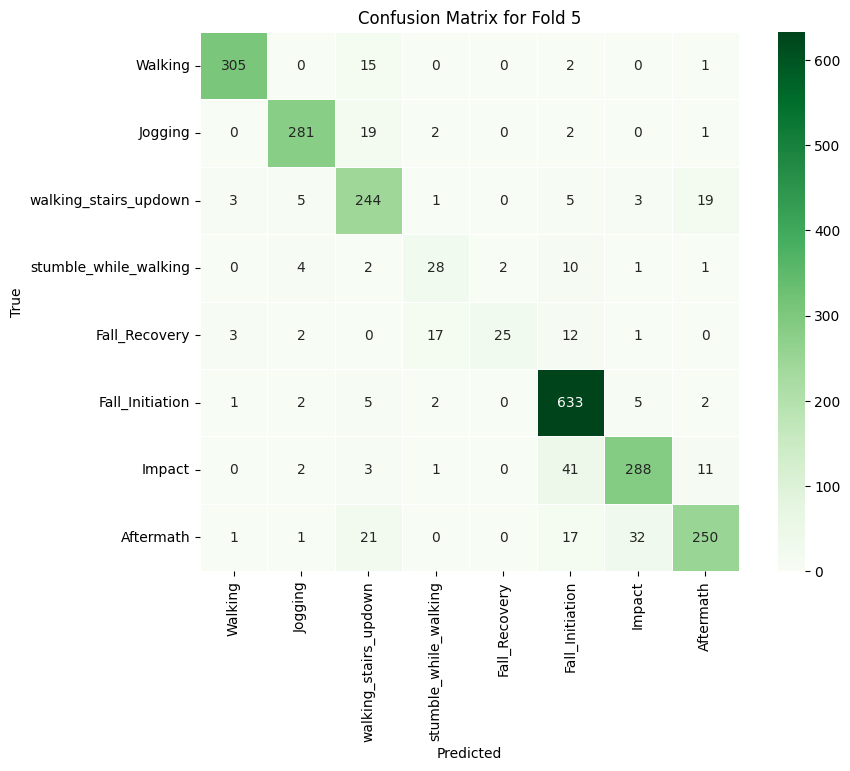

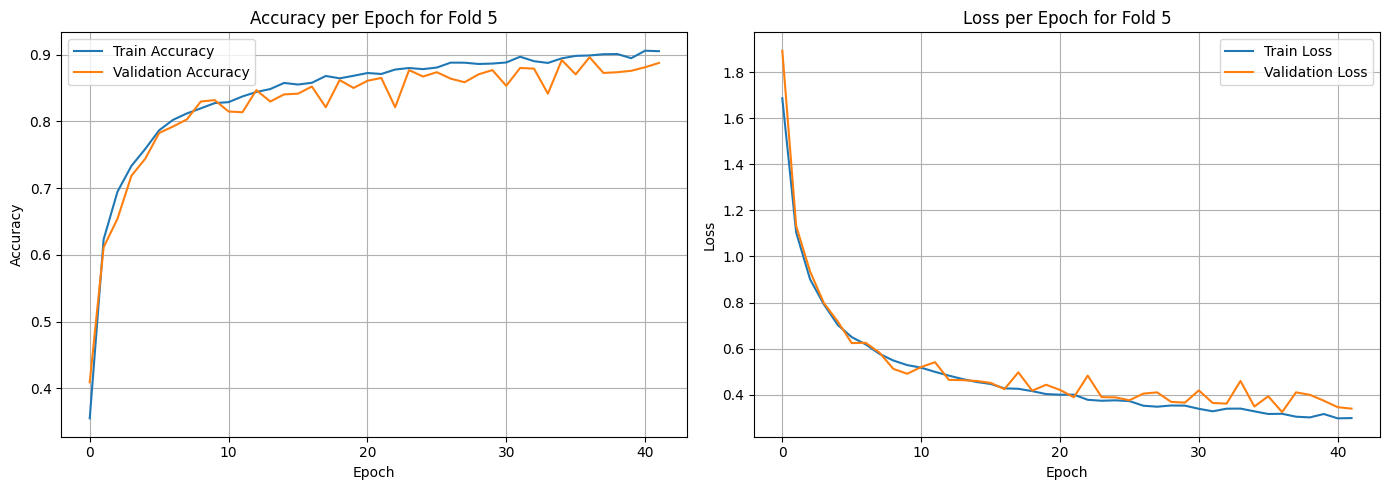

In [21]:
for train_index, test_index in kf.split(final_data):
    print(f"Fold {fold_no}")

    X_train, X_test = final_data[train_index], final_data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    model = ENSEMBLE(I_Shape, n_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=200,
        shuffle=True,
        validation_split=0.1,
        verbose=1,
        callbacks=[early_stopping]
    )

    loss, accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test, axis=1)

    precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    accuracies.append(accuracy)
    losses.append(loss)
    precisions.append(precision)
    recalls.append(recall)

    predictions = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(predictions, axis=1)

    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    print(pd.DataFrame(report).T)

    cm = confusion_matrix(y_true, y_pred)
    axis_labels = [label for label in class_labels]
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=0.5, square = True, cmap='Greens', xticklabels=axis_labels, yticklabels=axis_labels)
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy per Epoch for Fold {fold_no}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss per Epoch for Fold {fold_no}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    fold_no += 1

In [22]:
print("5-Fold Cross Validation Result")
print(f"Average Accuracy : {np.mean(accuracies):.4f}")
print(f"Average Precision : {np.mean(precisions):.4f}")
print(f"Average Recall : {np.mean(recalls):.4f}")
print(f"Average Loss : {np.mean(loss):.4f}")

5-Fold Cross Validation Result
Average Accuracy : 0.8726
Average Precision : 0.8724
Average Recall : 0.8726
Average Loss : 0.3669


In [23]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
h5_model = tf.keras.models.load_model('model.h5')
h5_loss, h5_accuracy = h5_model.evaluate(X_test, y_test)

73/73 [==============================] - 1s 7ms/step - loss: 0.3669 - accuracy: 0.8800


In [25]:
print(f'Model (.h5) Loss: {h5_loss:.4f}')
print(f'Model (.h5) Accuracy: {h5_accuracy:.4f}')

Model (.h5) Loss: 0.3669
Model (.h5) Accuracy: 0.8800


In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [27]:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

In [28]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [29]:
input_data = np.array(X_test, dtype=np.float32)
tflite_predictions = []

for i in range(input_data.shape[0]):
    interpreter.set_tensor(input_details[0]['index'], input_data[i:i+1])
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    tflite_predictions.append(output)

In [30]:
tflite_predictions = np.array(tflite_predictions).squeeze()
tflite_accuracy = np.mean(np.argmax(tflite_predictions, axis=1) == np.argmax(y_test, axis=1))

print(f'Model (.tflite) Accuracy : {tflite_accuracy:.4f}')

Model (.tflite) Accuracy : 0.8796


In [31]:
!xxd -i model.tflite > model.h